<h1>Restricted Boltzmann Machine</h1>
<h4>Copyright (c) 2018 Kristopher McBrian</h4>
Trained to represent the probability distribution of the 2D Ising Model

In [64]:
import numpy as np
import matplotlib.pyplot as plt

#Training Parameters -----------------------
data_set_size = 10000
batch_size = 20
num_batches = data_set_size/batch_size
num_epochs = 5
learning_rate = 0.13

In [65]:
#Model Parameters --------------------------

#Visible layer structure
n_v_r = 2
n_v_c = 3
N_v = n_v_r * n_v_c
#Hidden Layer structure
n_h_r = 1
n_h_c = 9
N_h = n_h_r * n_h_c

In [66]:
#Array Initialization ----------------------
width = np.sqrt(1./(N_v + N_h))
W = np.random.uniform(low=-width/2., high=width/2., size=(N_v*N_h)).reshape((n_v_r, n_v_c, n_h_r, n_h_c))
v_bias = np.ones(N_v).reshape(n_v_r, n_v_c)
h_bias = np.ones(N_h).reshape(n_h_r, n_h_c)

<h3>Obtaining the Training Set for the Restricted Boltzmann Machine</h3>
<blockquote>
    <p>Ising Model Hamiltonian</p>
    <p>Metropolis-Hastings Algorithm</p>
</blockquote>

In [67]:
#Hamiltonian for 2D Ising Model
#Calculates energy given a spin configuration
def H(spin):
    n_r,n_c  = spin.shape
    spin = 2*spin - 1 #maps {0,1} to {-1,1}
    H = 0.
    for i in range(n_r):
        for j in range(n_c):
            if j+1 != n_c: #if next index is not out of bounds
                H += spin[i,j]*spin[i,j+1]
            if i+1 != n_r:
                H += spin[i,j]*spin[i+1,j]
    return -H

def Met_Hast(n_v_r,n_v_c, T, num_iterations):
        #Random spin configuration
        spin = 2* np.random.randint(2,size = (n_v_r,n_v_c)) - 1 #{0,1} --> {-1,1}
        E = H(spin)
        data_set = np.zeros((num_iterations, n_v_r,n_v_c),dtype=int)
        
        for i in range(num_iterations):
            #Choose random coordinate on 2d lattice to flip
            x = np.random.randint(n_v_r)
            y = np.random.randint(n_v_c)
            spin[x,y] *= -1
            
            #Calculate energy change due to flipped spin
            neighbors = 0.
            if x != 0:
                neighbors += spin[x-1,y]
            if x != (n_v_r-1):
                neighbors += spin[x+1,y]
            if y != 0:
                neighbors += spin[x,y-1]
            if y != (n_v_c-1):
                neighbors += spin[x,y+1]

            dE = -2*spin[x,y]*neighbors

            #Accept or reject the flipped site
            if np.random.random() < np.exp(-dE/T):
                E += dE
            else:
                spin[x,y] *= -1

            #Add spin configuration to data set
            np.copyto(data_set[i,:,:], spin)
        return (data_set+1)/2 #{-1,1} --> {0,1}

T = 1. #Temperature of System
data_set = Met_Hast(n_v_r, n_v_c, T, data_set_size)
np.random.shuffle(data_set)

Obtain the probability distribution represented by the RBM and the exact model

In [68]:
def p_model(W, v_bias, h_bias, v_set):
    n_spin = len(v_set[0,0,:])
    n_v_r,n_v_c = v_bias.shape
    n_h_r,n_h_c = h_bias.shape
    p_model = np.zeros(n_spin)

    for spin in range(n_spin):
        c_ = 0.
        a_ = np.sum(v_bias*v_set[:,:,spin])
        for i in range(n_h_r):
            for j in range(n_h_c):
                b_ = np.sum(np.multiply(W[:,:,i,j], v_set[:,:,spin]))
                c_ += np.log(1 + np.exp(h_bias[i,j] + b_))
        p_model[spin] = np.exp(a_ + c_)
    Z = float(np.sum(p_model))
    return p_model/Z

def p_s(size, T):
    #size: tuple - (n_r, n_c)
    #Used in exact Hamiltonian models
    #   -calculate e^-(H(sig)/T) /Z
    N = size[0]*size[1]
    p_model = np.zeros(2**N)
    v_set = np.zeros((size[0],size[1],2**N)) #set of all possible spin configurations
    for i in range(len(p_model)):

        np.copyto(v_set[:,:,i], np.array([int(x) for x in np.binary_repr(i,width=N)]).reshape(size))
        p_model[i] = np.exp(-H(v_set[:,:,i])/T)
    Z = np.sum(p_model)
    return p_model/Z, v_set


p_exact,v_set = p_s((n_v_r, n_v_c), T)
p_model_before_train = p_model(W, v_bias, h_bias, v_set)

<h2>Gibb's Sampling</h2>
Called in the Train Function
<blockquote>
    <p>Calculate the probability that each hidden node has a value of 1, sampled against binomial distribution</p>
    <p>Calculate the probability that each visible node has a value of 1, sampled against binomial distribuition</p>
    <p>repeat k times</p>
</blockquote>

In [69]:
k = 5

def gibbs_sampling(k, v_0, W, v_bias, h_bias):
    v_k = np.zeros_like(v_0)
    h_0 = np.zeros_like(h_bias)
    h_k = np.zeros_like(h_bias)

    h_0 = gibbs_vtoh(W, v_0, h_bias)
    v_k = gibbs_htov(W, h_0, v_bias)
    for i in range(k):
        h_k = gibbs_vtoh(W, v_k, h_bias)
        v_k = gibbs_htov(W, h_k, v_bias)
    return v_k, h_0, h_k


def gibbs_vtoh(W, v, h_bias):
    activation=np.zeros_like(h_bias)
    for i in range(activation.shape[0]):
        for j in range(activation.shape[1]):
            activation[i,j] = sigmoid(h_bias[i,j] + np.sum(v*W[:,:,i,j]))

    h_k = np.random.binomial(1,activation,size=activation.shape)
    return h_k

def gibbs_htov(W, h, v_bias):
    activation=np.zeros_like(v_bias)
    for i in range(activation.shape[0]):
        for j in range(activation.shape[1]):
            activation[i,j] = sigmoid(v_bias[i,j] + np.sum(h*W[i,j,:,:]))

    v_k = np.random.binomial(1, activation, size=activation.shape)
    return v_k

def mult2dto4d(a,b):
    #element by element multiplication
    #Used to find change in weight values
    c = np.zeros((a.shape[0], a.shape[1], b.shape[0], b.shape[1]))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(b.shape[0]):
                for l in range(b.shape[1]):
                    c[i,j,k,l] = a[i,j]*b[k,l]
    return c

<h2>Training using Stochastic Gradient Descent</h2>
<blockquote>
    <p>Update parameter based on derivative of Kullback-Leibler Divergence</p>
    <p>Minimize the KL-Divergence</p>
</blockquote>

In [70]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def train(W, v_bias, h_bias, k, data_set, batch_size, num_batches, num_epochs, learning_rate):
    #Gradient Descent Arrays
    dW = np.zeros_like(W)
    dv_bias = np.zeros_like(v_bias)
    dh_bias = np.zeros_like(h_bias)

    #Gibbs Sampling Arrays
    v_0 = np.empty_like(v_bias, dtype=int)
    v_k = np.empty_like(v_bias, dtype=int)
    h_0 = np.empty_like(h_bias, dtype=int)
    h_k = np.empty_like(h_bias, dtype=int)

    num_data = data_set.shape[0]
    start = np.random.randint(num_data)

    for i_epoch in range(num_epochs):
        for i_batches in range(num_batches):
            dW *= 0.
            dv_bias *= 0.
            dh_bias *= 0.
            for i_input in range(batch_size):
                #gibbs sample
                v_0 = data_set[(i_input + start + batch_size*i_batches) % num_data,:,:]
                v_k, h_0, h_k = gibbs_sampling(k, v_0, W, v_bias, h_bias)

                #assign dW, dv_bias, ...
                dW += mult2dto4d(v_0, h_0) - mult2dto4d(v_k, h_k)
                dv_bias += v_0 - v_k
                dh_bias += h_0 - h_k

            np.copyto(W, W + dW * learning_rate/batch_size)
            np.copyto(v_bias, v_bias + dv_bias * learning_rate/batch_size)
            np.copyto(h_bias, h_bias + dh_bias * learning_rate/batch_size)
            if i_batches % 100 == 0:
                print 'Epoch: %d/%d'%(i_epoch+1, num_epochs), ' Batch: %d/%d'%(i_batches, num_batches)
    return W, v_bias, h_bias


W, v_bias, h_bias = train(W, v_bias, h_bias, k, data_set, batch_size, num_batches, num_epochs, learning_rate)
p_model_after_train = p_model(W, v_bias, h_bias, v_set)

Epoch: 0/4  Batch: 0/500
Epoch: 0/4  Batch: 100/500
Epoch: 0/4  Batch: 200/500
Epoch: 0/4  Batch: 300/500
Epoch: 0/4  Batch: 400/500
Epoch: 1/4  Batch: 0/500
Epoch: 1/4  Batch: 100/500
Epoch: 1/4  Batch: 200/500
Epoch: 1/4  Batch: 300/500
Epoch: 1/4  Batch: 400/500
Epoch: 2/4  Batch: 0/500
Epoch: 2/4  Batch: 100/500
Epoch: 2/4  Batch: 200/500
Epoch: 2/4  Batch: 300/500
Epoch: 2/4  Batch: 400/500
Epoch: 3/4  Batch: 0/500
Epoch: 3/4  Batch: 100/500
Epoch: 3/4  Batch: 200/500
Epoch: 3/4  Batch: 300/500
Epoch: 3/4  Batch: 400/500
Epoch: 4/4  Batch: 0/500
Epoch: 4/4  Batch: 100/500
Epoch: 4/4  Batch: 200/500
Epoch: 4/4  Batch: 300/500
Epoch: 4/4  Batch: 400/500


In [71]:
def KL_div(exact, model):
    A = 0.
    for i in range(len(exact)):
        A +=  exact[i] * np.log(exact[i]/model[i])
    return A

KL_b = KL_div(p_exact, p_model_before_train)
KL_a = KL_div(p_exact, p_model_after_train)

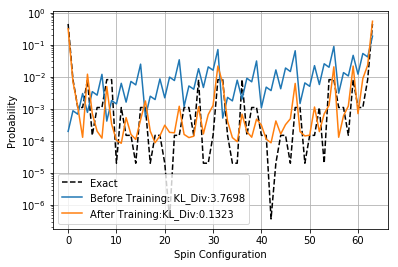

In [72]:
plt.figure()

plt.plot(p_exact, 'k--',label='Exact')
plt.plot(p_model_before_train, label='Before Training: KL_Div:%.4f'%KL_b)
plt.plot(p_model_after_train, label='After Training:KL_Div:%.4f'%KL_a)

plt.yscale('log')
plt.ylabel("Probability")
plt.xlabel("Spin Configuration")
plt.grid(True)
plt.legend(loc='best')
plt.show()

<h3>Sources</h3>
<blockquote>
    <p>Torlai, Giacomo, and Roger G. Melko. "Learning thermodynamics with Boltzmann machines." Physical Review B 94.16 (2016): 165134.</p>
    <p>Hinton, Geoffrey E. "Training products of experts by minimizing contrastive divergence." Neural computation 14.8 (2002): 1771-1800.</p>
    <p>Morningstar, Alan, and Roger G. Melko. "Deep learning the Ising model near criticality." arXiv preprint arXiv:1708.04622 (2017).</p>
</blockquote>